<a href="https://colab.research.google.com/github/superwise-ai/ml-pipeline/blob/main/notebook/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

In [ ]:
%env PROJECT_ID=''

In [ ]:
USERNAME = "<lowercase user name>" # @param username
BUCKET_NAME = "gs://<USED BUCKET>" # @param bucket name
REGION = "<REGION>" # @param region
PROJECT_ID = "<GCP PROJECT ID>" # @param project id
PROJECT_NUMBER = "<GCP PROJECT NUMBER>" # @param project number
PIPELINE_NAME = f"workshop-diamonds-predictor-{USERNAME}" 


import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

#### Create Workshop's Bucket

In [ ]:
!gcloud config set project $PROJECT_ID

Updated property [core/project].


Next command will create a bucket

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

#### Validate access to bucket

In [ ]:
! gsutil ls -al $BUCKET_NAME

#### Install Google packages

In [ ]:
## If in Google Colab add 
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

# Install ai platform and kfp
!pip3 install {USER_FLAG} google-cloud-aiplatform==1.7.0 --upgrade
!pip3 install {USER_FLAG} kfp --upgrade
!pip3 install google_cloud_pipeline_components

Once everything is installed need to restart kernel

In [ ]:
import os

# Automatically restart kernel after installs
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

###### Enable APIs (Optional)

In [ ]:
!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com

Operation "operations/acat.p2-1033395281527-32d9b012-0733-4acc-b385-5a0812e7775c" finished successfully.


#### Import Vertex SDK for Python

Import the Vertex SDK for Python into your Python environment and initialize it.

In [ ]:
USERNAME = "<lowercase user name>" # @param username
BUCKET_NAME = "gs://<USED BUCKET>" # @param bucket name
REGION = "<REGION>" # @param region
PROJECT_ID = "<GCP PROJECT ID>" # @param project id
PROJECT_NUMBER = "<GCP PROJECT NUMBER>" # @param project number
PIPELINE_NAME = f"workshop-diamonds-predictor-{USERNAME}"
ARTIFACT_REGISTRY_NAME = "diamonds-predictor-repo"


In [ ]:
import os
import sys

from typing import List, NamedTuple
from datetime import datetime

from google.cloud import aiplatform, storage
from google.cloud.aiplatform import gapic as aip
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import component, pipeline, Input, Output, Model, Metrics, Dataset, HTML


aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


#### Vertex definitions

In [ ]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
PIPELINE_ROOT = "{}/{}_pipeline_root/workshop".format(BUCKET_NAME, USERNAME)

## Building the Pipeline

#### Load the data Component

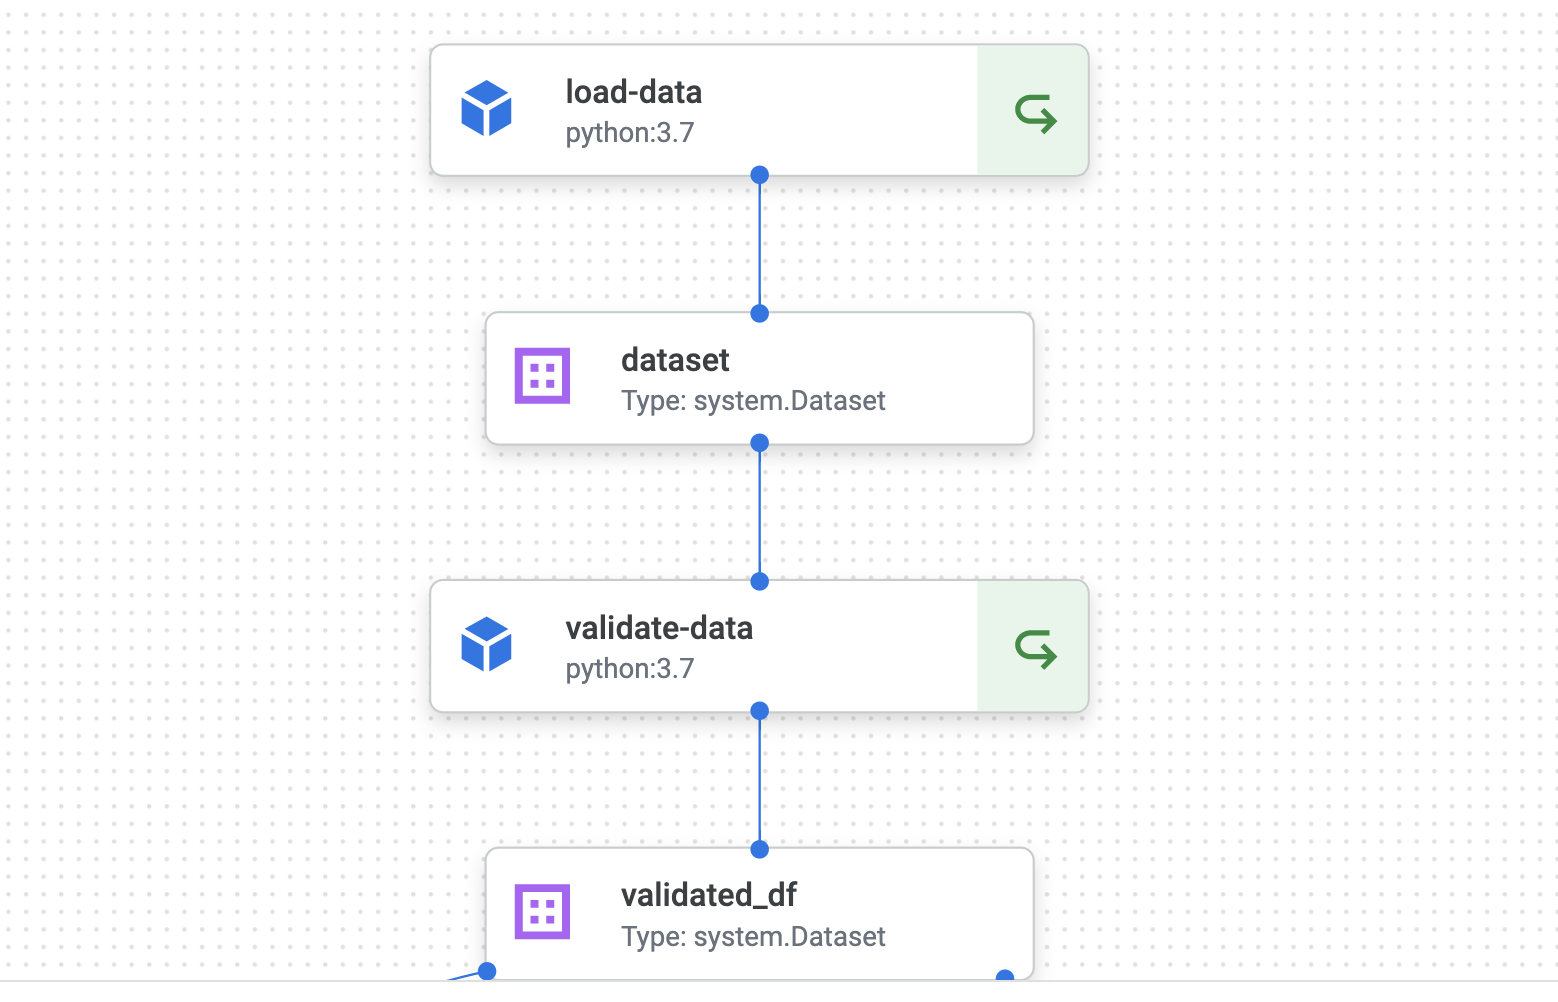

In [ ]:
@component(packages_to_install=["pandas"])
def load_data(dataset: Output[Dataset]):
    import pandas as pd

    df = pd.read_csv("https://www.openml.org/data/get_csv/21792853/dataset")
    df = df[df["price"] < 10000]
    print("Load Data: ", df.head())
    df.to_csv(dataset.path, index=False)

In [ ]:
import pandas as pd
pd.read_csv("https://www.openml.org/data/get_csv/21792853/dataset").head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


##### Diamonds Dataset Features

```
- price - price in US dollars (\$326--\$18,823)
- carat - weight of the diamond (0.2--5.01)
- cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color - diamond colour, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)
```

#### Validate the data Component

In [ ]:
@component(packages_to_install=["pandas"])
def validate_data(df: Input[Dataset], validated_df: Output[Dataset]):
    import pandas as pd

    df = pd.read_csv(df.path)
    print("Validate_data: ", df.head())
    BINARY_FEATURES = []
    # List all column names for numeric features
    NUMERIC_FEATURES = ["carat", "depth", "table", "x", "y", "z"]
    # List all column names for categorical features
    CATEGORICAL_FEATURES = ["cut", "color", "clarity"]
    # ID column - needed to support predict() over numpy arrays
    ID = ["record_id"]
    TARGET = "price"
    ALL_COLUMNS = ID + BINARY_FEATURES + NUMERIC_FEATURES + CATEGORICAL_FEATURES
    # define the column name for the target
    df = df.reset_index().rename(columns={"index": "record_id"})
    for n in NUMERIC_FEATURES:
        df[n] = pd.to_numeric(df[n], errors="coerce")

    df = df.fillna(df.mean(numeric_only=True))

    def data_selection(df: pd.DataFrame, selected_columns: List[str]):
        selected_columns.append(TARGET)
        data = df.loc[:, selected_columns]
        return data

    ## Feature selection
    df = data_selection(df, ALL_COLUMNS)
    return df.to_csv(validated_df.path, index=False)

#### Prepare data for training Component

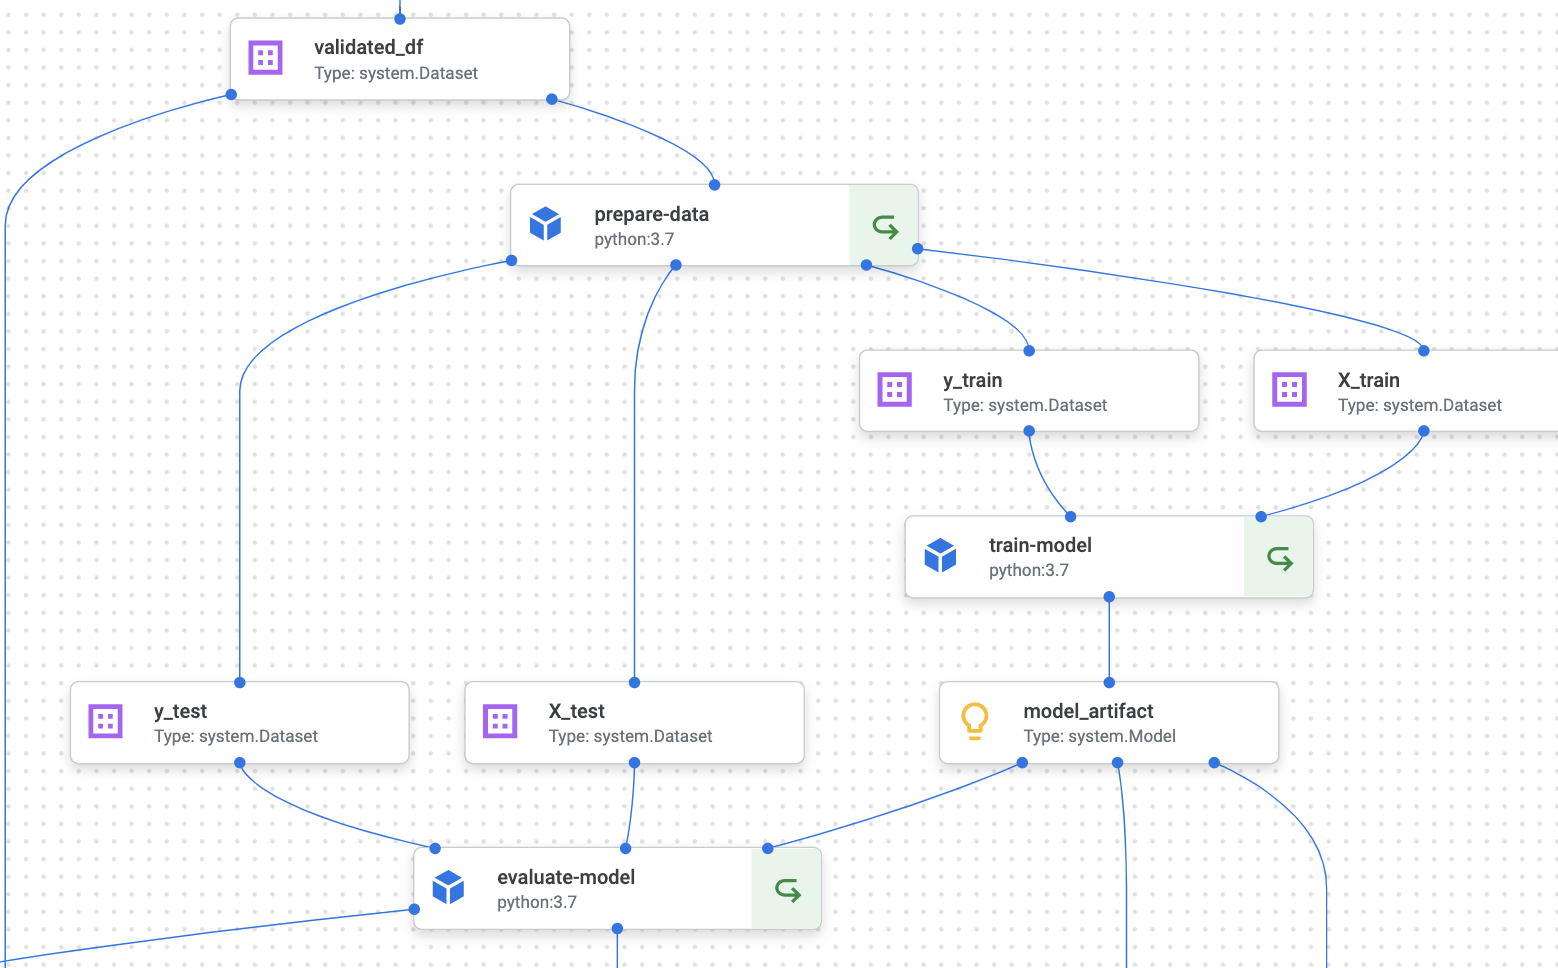

In [ ]:
@component(packages_to_install=["scikit-learn==1.0.2", "pandas"])
def prepare_data(
    df: Input[Dataset],
    X_train: Output[Dataset],
    y_train: Output[Dataset],
    X_test: Output[Dataset],
    y_test: Output[Dataset],
):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    target = "price"
    df = pd.read_csv(df.path)
    print("Prepare data: ", df.head())
    X, y = df.drop(columns=[target]), df[target]

    X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train_data.to_csv(X_train.path, index=False)
    y_train_data.to_csv(y_train.path, index=False)
    X_test_data.to_csv(X_test.path, index=False)
    y_test_data.to_csv(y_test.path, index=False)

#### Train model Component

In [ ]:
@component(packages_to_install=["scikit-learn==1.0.2", "pandas", "joblib"])
def train_model(
    X_train: Input[Dataset],
    y_train: Input[Dataset],
    model_artifact: Output[Model],
):
    import joblib
    import pandas as pd

    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_val_score

    # List all column names for numeric features
    NUMERIC_FEATURES = ["carat", "depth", "table", "x", "y", "z"]
    # List all column names for categorical features
    CATEGORICAL_FEATURES = ["cut", "color", "clarity"]
    # ID column - needed to support predict() over numpy arrays
    ID = ["record_id"]
    ALL_COLUMNS = ID + NUMERIC_FEATURES + CATEGORICAL_FEATURES

    X, y = pd.read_csv(X_train.path), pd.read_csv(y_train.path)
    X = X.loc[:, ALL_COLUMNS]
    print("Trainning model X:", X.head(), "Y: ", y.head())
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("cat", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUMERIC_FEATURES),
            ("cat", categorical_transformer, CATEGORICAL_FEATURES),
        ],
        remainder="drop",
        n_jobs=-1,
    )
    # We now create a full pipeline, for preprocessing and training.
    # for training we selected a RandomForestRegressor
    model_params = {"max_features": "auto",
                    "n_estimators": 500,
                    "max_depth": 9,
                    "random_state": 42}

    regressor = RandomForestRegressor()
    regressor.set_params(**model_params)
    # steps=[('i', SimpleImputer(strategy='median'))
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", regressor)]
    )
    # For Workshop time efficiency we will use 1-fold cross validation
    score = cross_val_score(
        pipeline, X, y, cv=2, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()
    print("finished cross val")
    # Now we fit all our data to the classifier.
    pipeline.fit(X, y)

    # Upload the model to GCS
    joblib.dump(pipeline, model_artifact.path, compress=3)

    model_artifact.metadata["train_score"] = score

#### Evaluate the model Component

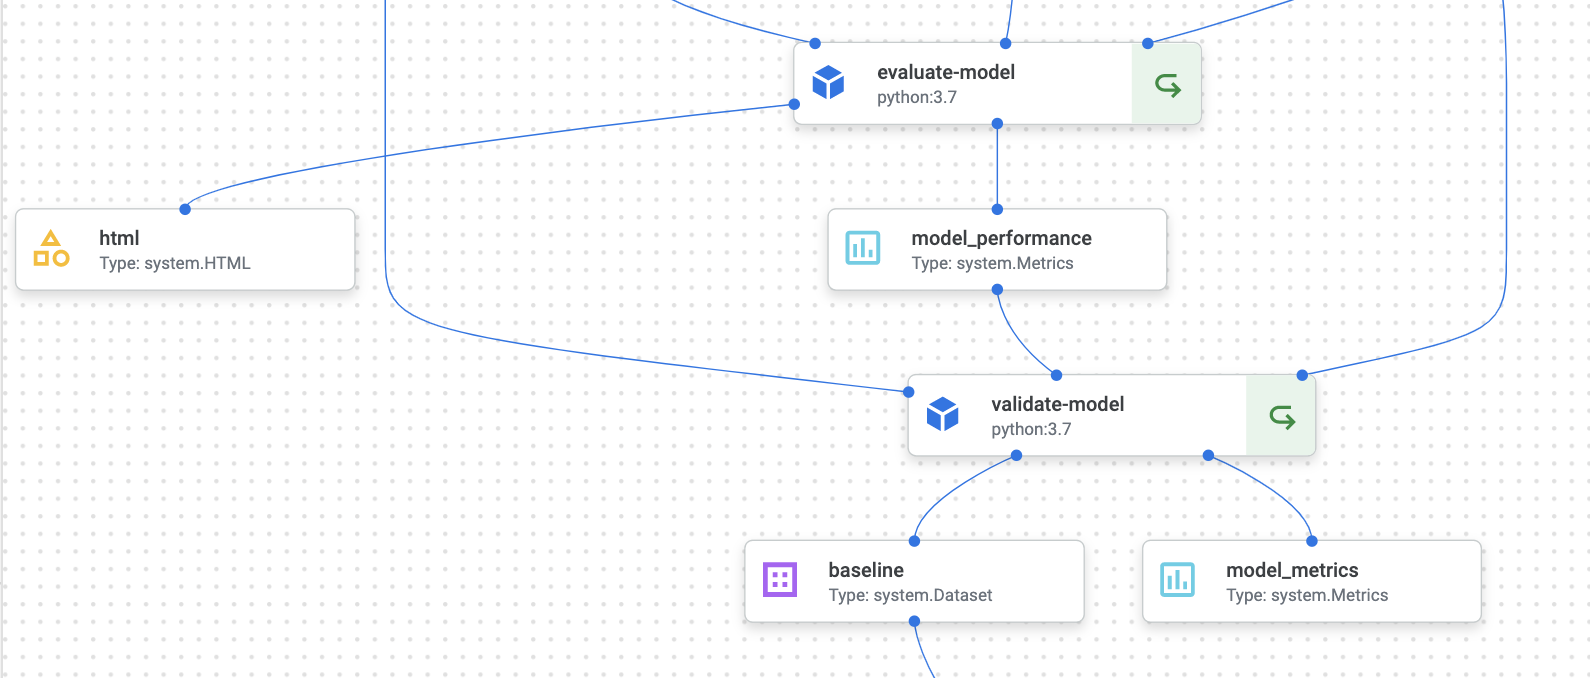

In [ ]:
@component(
    packages_to_install=["scikit-learn==1.0.2", "pandas", "seaborn", "matplotlib"]
)
def evaluate_model(
    model_artifact: Input[Model],
    x_test: Input[Dataset],
    y_test: Input[Dataset],
    model_performance: Output[Metrics],
    html: Output[HTML],
):
    import joblib
    import io
    import base64
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt
    
    from math import sqrt
    from sklearn.metrics import mean_squared_error, r2_score

    model = joblib.load(model_artifact.path)

    y_test = pd.read_csv(y_test.path)["price"]
    y_pred = model.predict(pd.read_csv(x_test.path))
    model_performance.metadata["rmse"] = sqrt(mean_squared_error(y_test, y_pred))
    model_performance.metadata["r2"] = r2_score(y_test, y_pred)
    model_performance.log_metric("r2", model_performance.metadata["r2"])
    model_performance.log_metric("rmse", model_performance.metadata["rmse"])

    df = pd.DataFrame({"predicted Price(USD)": y_pred, "actual Price(USD)": y_test})

    def fig_to_base64(fig):
        img = io.BytesIO()
        fig.get_figure().savefig(img, format="png", bbox_inches="tight")
        img.seek(0)

        return base64.b64encode(img.getvalue())

    encoded = fig_to_base64(
        sns.scatterplot(data=df, x="predicted Price(USD)", y="actual Price(USD)")
    )
    encoded_html = "{}".format(encoded.decode("utf-8"))
    html_content = '<html><head></head><body><h1>Predicted vs Actual Price</h1>\n<img src="data:image/png;base64, {}"></body></html>'.format(
        encoded_html
    )

    with open(html.path, "w") as f:
        f.write(html_content)

#### Validate the model Component

In [ ]:
@component(packages_to_install=["scikit-learn==1.0.2", "pandas"])
def validate_model(
    new_model_metrics: Input[Metrics],
    new_model: Input[Model],
    dataset: Input[Dataset],
    baseline: Output[Dataset],
    model_metrics: Output[Metrics],
) -> NamedTuple("output", [("deploy", str)]):
    import joblib
    import pandas as pd
    
    from math import sqrt
    from sklearn.metrics import mean_squared_error, r2_score

    target = "price"
    validation_data = pd.read_csv(dataset.path)
    X, y = validation_data.drop(columns=[target]), validation_data[target]

    model = joblib.load(new_model.path)
    y_pred = model.predict(X)
    rmse = sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    train_score = new_model.metadata["train_score"]
    print("new model rmse cross validation mean score: ", train_score)
    print("new model train rmse: ", new_model_metrics.metadata["rmse"])
    print("new model train r2: ", new_model_metrics.metadata["r2"])
    print("new model validation rmse: ", rmse)
    print("new model validation r2: ", r2)

    model_metrics.log_metric("rmse", rmse)
    model_metrics.log_metric("r2", r2)

    validation_data["predictions"] = y_pred
    validation_data.to_csv(baseline.path, index=False)

    if (
        rmse <= new_model_metrics.metadata["rmse"]
        and new_model_metrics.metadata["r2"] >= 0.95
        and abs(train_score) < 1000
    ):
        return ("true",)

    return ("false",)

## Generate a pipeline

#### Extract Data - Validate Model Pipeline

In [ ]:
@pipeline(
    name=PIPELINE_NAME,
    description="An ml pipeline",
    pipeline_root=PIPELINE_ROOT,
)
def ml_pipeline():
    raw_data = load_data()
    validated_data = validate_data(raw_data.outputs["dataset"])
    prepared_data = prepare_data(validated_data.outputs["validated_df"])
    trained_model_task = train_model(
        prepared_data.outputs["X_train"], prepared_data.outputs["y_train"]
    )
    evaluated_model = evaluate_model(
        trained_model_task.outputs["model_artifact"],
        prepared_data.outputs["X_test"],
        prepared_data.outputs["y_test"],
    )
    validated_model = validate_model(
        new_model_metrics=evaluated_model.outputs["model_performance"],
        new_model=trained_model_task.outputs["model_artifact"],
        dataset=validated_data.outputs["validated_df"],
    )

#### Execute Basic Pipeline

In [ ]:
## GET UNIQUE VALUE
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")


ml_pipeline_file = "ml_pipeline.json"

compiler.Compiler().compile(
    pipeline_func=ml_pipeline, package_path=ml_pipeline_file
)

job = aiplatform.PipelineJob(
    display_name="diamonds-predictor-pipeline",
    template_path=ml_pipeline_file,
    job_id="basic-pipeline-{}-{}".format(USERNAME, TIMESTAMP),
    enable_caching=True,
)

job.submit()

## Add the Model to Superwise and Deploy 

#### Register model to Superwise Component

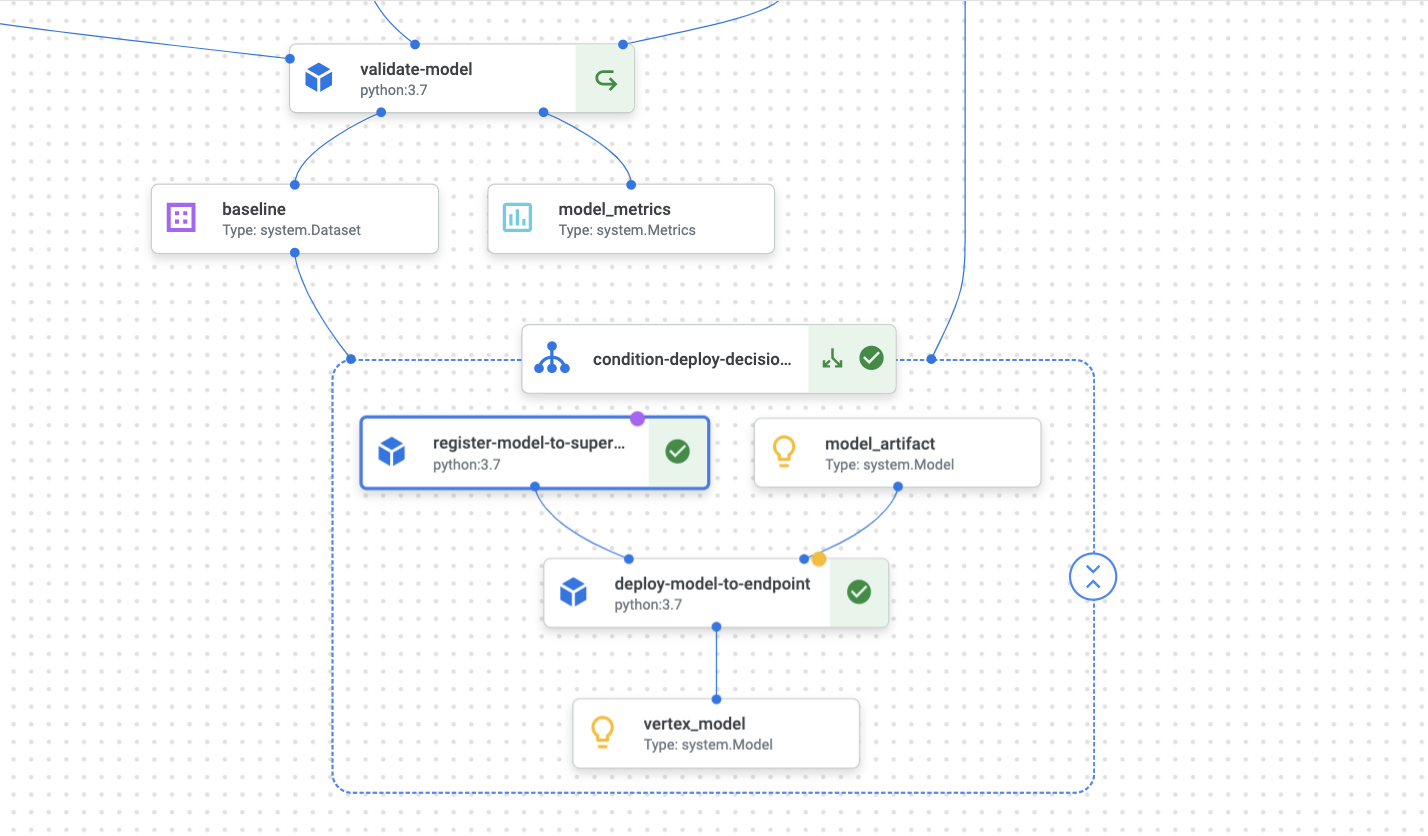

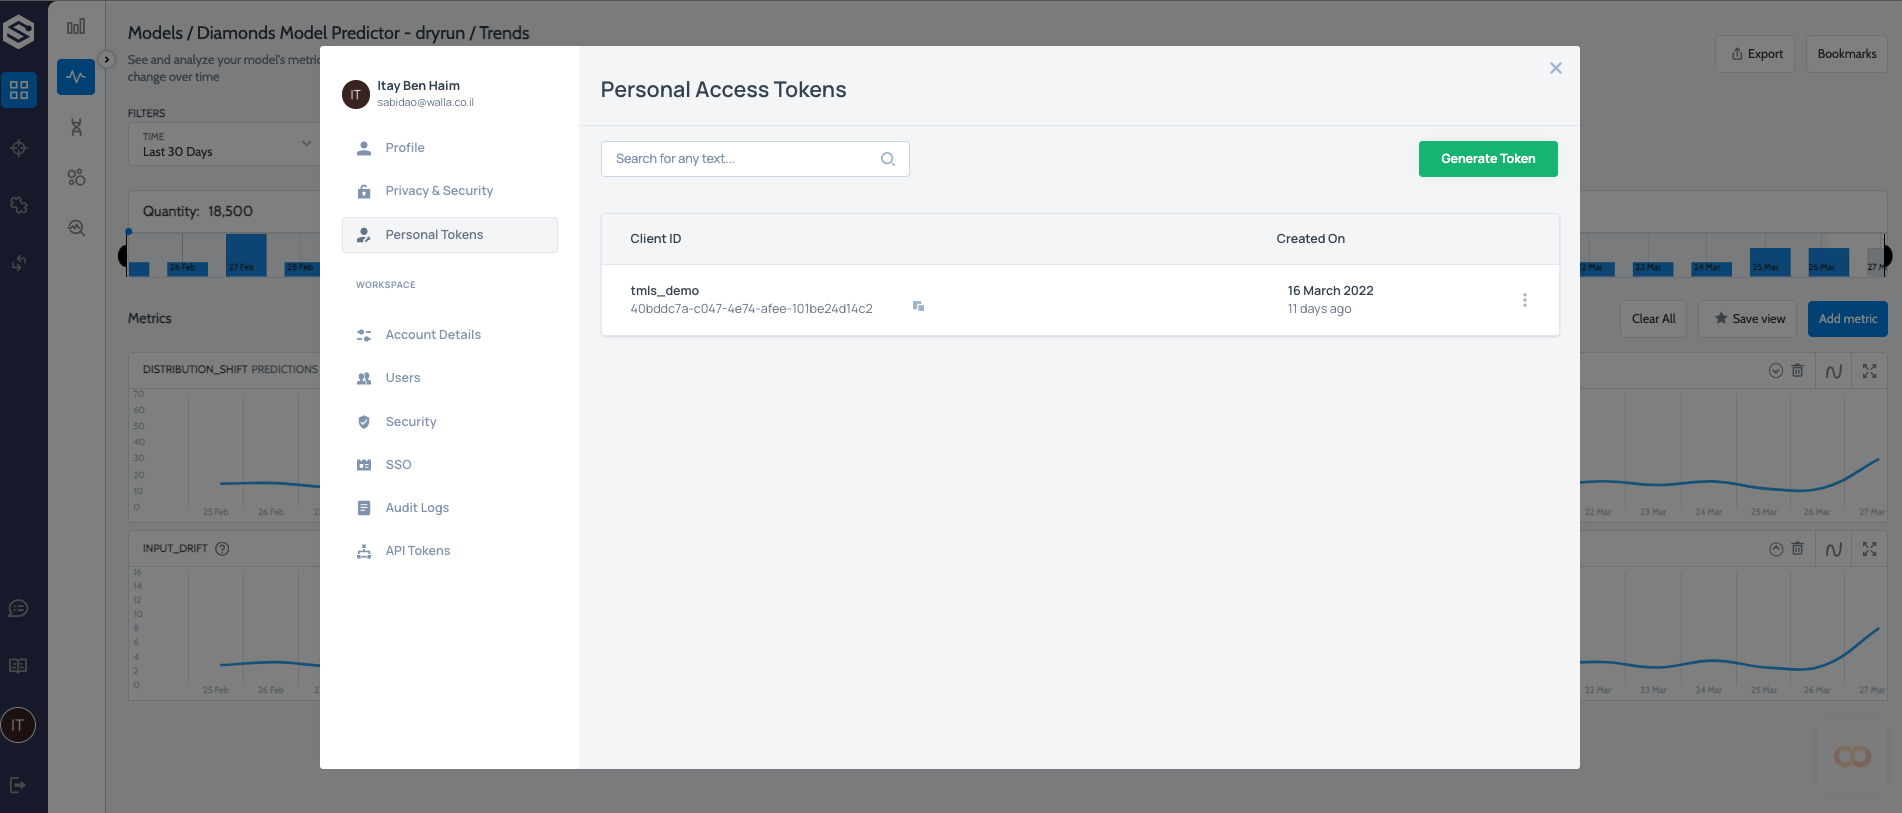

In [ ]:
SUPERWISE_CLIENT_ID="<YOUR SUPERWISE ACCOUNT CLIENT ID>" # @param project number
SUPERWISE_SECRET="<YOUR SUPERWISE ACCOUNT SECRET>"# @param project number
SUPERWISE_MODEL_NAME = "Regression - Diamonds Price Predictor"

@component(packages_to_install=["superwise", "pandas"])
def register_model_to_superwise(
    model_name: str,
    superwise_client_id: str,
    superwise_secret: str,
    baseline: Input[Dataset],
    timestamp: str,
) -> NamedTuple("output", [("superwise_model_id", int), ("superwise_version_id", int)]):
    import pandas as pd
    
    from datetime import datetime
    from superwise import Superwise
    from superwise.models.model import Model
    from superwise.models.version import Version
    from superwise.resources.superwise_enums import DataEntityRole
    from superwise.controller.infer import infer_dtype

    sw = Superwise(
        client_id=superwise_client_id,
        secret=superwise_secret,
    )

    first_version = False
    # Check if model exists
    models = sw.model.get_by_name(model_name)
    if len(models) == 0:
        print(f"Registering new model {model_name} to Superwise")
        diamond_model = Model(name=model_name, description="Predicting Diamond Prices")
        new_model = sw.model.create(diamond_model)
        model_id = new_model.id
        first_version = True
    else:
        print(f"Model {model_name} already exists in Superwise")
        model_id = models[0].id

    baseline_data = pd.read_csv(baseline.path).assign(
        ts=pd.Timestamp.now() - pd.Timedelta(30, "d")
    )
    # infer baseline data types and calculate metrics & distribution for features
    entities_dtypes = infer_dtype(df=baseline_data)
    entities_collection = sw.data_entity.summarise(
        data=baseline_data,
        entities_dtypes=entities_dtypes,
        specific_roles={
            "record_id": DataEntityRole.ID,
            "ts": DataEntityRole.TIMESTAMP,
            "predictions": DataEntityRole.PREDICTION_VALUE,
            "price": DataEntityRole.LABEL,
        },
    )

    if not first_version:
        model_versions = sw.version.get({"model_id": model_id})
        print(
            f"Model already has the following versions: {[v.name for v in model_versions]}"
        )

    new_version_name = f"v_{timestamp}"
    # create new version for model in Superwise
    diamond_version = Version(
        model_id=model_id,
        name=new_version_name,
        data_entities=entities_collection,
    )
    new_version = sw.version.create(diamond_version)
    # activate the new version for monitoring
    sw.version.activate(new_version.id)
    return (model_id, new_version.id)


#### Register to Superwise pipeline

In [ ]:
@pipeline(
    name=PIPELINE_NAME,
    description="An ml pipeline",
    pipeline_root=PIPELINE_ROOT,
)
def ml_pipeline():
    raw_data = load_data()
    validated_data = validate_data(raw_data.outputs["dataset"])
    prepared_data = prepare_data(validated_data.outputs["validated_df"])
    trained_model_task = train_model(
        prepared_data.outputs["X_train"], prepared_data.outputs["y_train"]
    )
    evaluated_model = evaluate_model(
        trained_model_task.outputs["model_artifact"],
        prepared_data.outputs["X_test"],
        prepared_data.outputs["y_test"],
    )
    validated_model = validate_model(
        new_model_metrics=evaluated_model.outputs["model_performance"],
        new_model=trained_model_task.outputs["model_artifact"],
        dataset=validated_data.outputs["validated_df"],
    )
    with dsl.Condition(
        validated_model.outputs["deploy"] == "true", name="deploy_decision"
    ):
        superwise_metadata = register_model_to_superwise(
            SUPERWISE_MODEL_NAME,
            SUPERWISE_CLIENT_ID,
            SUPERWISE_SECRET,
            validated_model.outputs["baseline"],
            TIMESTAMP,
        )

#### Execute Register to Superwise pipeline

In [ ]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

ml_pipeline_file = "ml_pipeline.json"

compiler.Compiler().compile(
    pipeline_func=ml_pipeline, package_path=ml_pipeline_file
)

job = aiplatform.PipelineJob(
    display_name="diamonds-predictor-pipeline",
    template_path=ml_pipeline_file,
    job_id="superwise-pipeline-{}-{}".format(USERNAME, TIMESTAMP),
    enable_caching=True,
)

job.submit()

## Implement model's predict and log image

[Simple Flask Prediction App](https://github.com/superwise-ai/model-orchestration)

ssh: `git clone -b workshop git@github.com:superwise-ai/model-orchestration.git`

https: `git clone -b workshop https://github.com/superwise-ai/model-orchestration.git`

## Deploy Diamonds-Prediction Image to Endpoint

#### Deploy to Endpoint Component

In [ ]:
@component(
    packages_to_install=[
        "google-cloud-aiplatform==1.7.0",
        "google-cloud-pipeline-components",
    ]
)
def deploy_model_to_endpoint(
    project: str,
    location: str,
    bucket_name: str,
    timestamp: str,
    superwise_client_id: str,
    superwise_secret: str,
    superwise_model_id: int,
    superwise_version_id: int,
    serving_container_image_uri: str,
    model: Input[Model],
    vertex_model: Output[Model],
):
    import os
    from google.cloud import aiplatform, storage

    aiplatform.init(project=project, location=location)

    DISPLAY_NAME = "Diamonds-Price-Predictor"

    def create_endpoint():
        endpoints = aiplatform.Endpoint.list(
            filter='display_name="{}"'.format(DISPLAY_NAME),
            order_by="create_time desc",
            project=project,
            location=location,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0]  # most recently created
        else:
            endpoint = aiplatform.Endpoint.create(
                display_name=DISPLAY_NAME, project=project, location=location
            )
        return endpoint

    def upload_model_to_gcs(artifact_filename, local_path):
        model_directory = f"{bucket_name}/models/"
        storage_path = os.path.join(model_directory, artifact_filename)
        blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
        blob.upload_from_filename(local_path)
        return f"models/{artifact_filename}"

    endpoint = create_endpoint()
    model_gcs_path = upload_model_to_gcs(f"model_{timestamp}.joblib", model.path)
    model_upload = aiplatform.Model.upload(
        display_name=DISPLAY_NAME,
        serving_container_image_uri=serving_container_image_uri,
        serving_container_ports=[5050],
        serving_container_health_route=f"/diamonds/v1",
        serving_container_predict_route=f"/diamonds/v1/predict",
        serving_container_environment_variables={
            "MODEL_PATH": model_gcs_path,
            "BUCKET_NAME": bucket_name.strip("gs://"),
            "SUPERWISE_CLIENT_ID": superwise_client_id,
            "SUPERWISE_SECRET": superwise_secret,
            "SUPERWISE_MODEL_ID": superwise_model_id,
            "SUPERWISE_VERSION_ID": superwise_version_id,
        },
    )
    print("uploaded version")
    model_deploy = model_upload.deploy(
        machine_type="n1-standard-4",
        endpoint=endpoint,
        traffic_split={"0": 100},
        deployed_model_display_name=DISPLAY_NAME,
    )
    vertex_model.uri = model_deploy.resource_name

#### End to Endpoint Pipeline

In [ ]:
@pipeline(
    name=PIPELINE_NAME,
    description="An ml pipeline",
    pipeline_root=PIPELINE_ROOT,
)
def ml_pipeline():
    raw_data = load_data()
    validated_data = validate_data(raw_data.outputs["dataset"])
    prepared_data = prepare_data(validated_data.outputs["validated_df"])
    trained_model_task = train_model(
        prepared_data.outputs["X_train"], prepared_data.outputs["y_train"]
    )
    evaluated_model = evaluate_model(
        trained_model_task.outputs["model_artifact"],
        prepared_data.outputs["X_test"],
        prepared_data.outputs["y_test"],
    )
    validated_model = validate_model(
        new_model_metrics=evaluated_model.outputs["model_performance"],
        new_model=trained_model_task.outputs["model_artifact"],
        dataset=validated_data.outputs["validated_df"],
    )
    with dsl.Condition(
        validated_model.outputs["deploy"] == "true", name="deploy_decision"
    ):
        superwise_metadata = register_model_to_superwise(
            SUPERWISE_MODEL_NAME,
            SUPERWISE_CLIENT_ID,
            SUPERWISE_SECRET,
            validated_model.outputs["baseline"],
            TIMESTAMP,
        )
        vertex_model = deploy_model_to_endpoint(
            PROJECT_ID,
            REGION,
            BUCKET_NAME,
            TIMESTAMP,
            SUPERWISE_CLIENT_ID,
            SUPERWISE_SECRET,
            superwise_metadata.outputs["superwise_model_id"],
            superwise_metadata.outputs["superwise_version_id"],
            f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY_NAME}/diamonds_predictor:latest",
            trained_model_task.outputs["model_artifact"],
        )


In [ ]:
!ls -ltr ## ml_pipeline.json has been created

#### Execute End to Endpoint pipeline

In [ ]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

ml_pipeline_file = "ml_pipeline.json"

compiler.Compiler().compile(
    pipeline_func=ml_pipeline, package_path=ml_pipeline_file
)

job = aiplatform.PipelineJob(
    display_name="diamonds-predictor-pipeline",
    template_path=ml_pipeline_file,
    job_id="e2e-pipeline-{}-{}".format(USERNAME, TIMESTAMP),
    enable_caching=True,
)

upload_blob(
    bucket_name=BUCKET_NAME.strip("gs://"),
    source_file_name=ml_pipeline_file,
    destination_blob_name=ml_pipeline_file,
)

job.submit()

## Simulate real world data **stream**

In [ ]:
import requests
import json
import pandas as pd
import google.auth
import google.auth.transport.requests

ENDPOINT_ID = "<GET THE ENDPOINT_ID FROM THE PIPELINE'S OUTPUT>"
url = f"https://{REGION}-aiplatform.googleapis.com/v1/projects/{PROJECT_NUMBER}/locations/{REGION}/endpoints/{ENDPOINT_ID}:predict"
                                                      
credentials, project_id = google.auth.default(
    scopes=[
        "https://www.googleapis.com/auth/cloud-platform",
        "https://www.googleapis.com/auth/cloud-platform.read-only",
    ]
)

instances = {"instances": []}
df = pd.read_csv("https://www.openml.org/data/get_csv/21792853/dataset")
expensive_df = df[df["price"] > 10000].sort_values("price", ascending=False)
df = df[df["price"] < 10000]

count = 30
chunk_size = 500
reset_index = True
min_chunk, max_chunk = 0, chunk_size
while count:
    print(count)
    print(f"Uploading data from: {str(pd.Timestamp.now() - pd.Timedelta(count, 'd'))}")
    if count < 10:
        if reset_index:
          min_chunk, max_chunk = 0, 500
          reset_index = False
        print(expensive_df.iloc[min_chunk:max_chunk]['price'].mean())
        for row_tuple in expensive_df.iloc[min_chunk:max_chunk].iterrows():  
            row_dict = row_tuple[1].drop("price").to_dict()
            row_dict["record_id"] = row_tuple[1].name
            row_dict["ts"] = str(pd.Timestamp.now() - pd.Timedelta(count, 'd'))
            instances["instances"].append(row_dict)        
    else:
        print(df.iloc[min_chunk:max_chunk]['price'].mean())
        for row_tuple in df.iloc[min_chunk:max_chunk].iterrows():
            row_dict = row_tuple[1].drop("price").to_dict()
            row_dict["record_id"] = row_tuple[1].name
            row_dict["ts"] = str(pd.Timestamp.now() - pd.Timedelta(count, 'd'))
            instances["instances"].append(row_dict)

    request = google.auth.transport.requests.Request()
    credentials.refresh(request)
    token = credentials.token
    headers = {"Authorization": "Bearer " + token}
    response = requests.post(url, json=instances, headers=headers)
    #print(response.text) ## If needed :)
    print("---" * 15)
    instances["instances"] = []
    count -= 1
    min_chunk += chunk_size
    max_chunk += chunk_size